In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
path_to_file = 'ara.txt'
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [8]:
# now we will convert the data from unicode to ascii
def unicode_to_ascii(s):
  # this line of code convert each unistr to and remove the accent 
  return ''.join(c for c in unicodedata.normalize('NFD', s)
  # return all this exept the nonspacing mark
      if unicodedata.category(c) != 'Mn')

In [9]:
# now we will create a function to process or sentence
def preprocess_sentence(w):
  # first thing we will convert the unicode to ascii
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?؟.!,¿])", r" \1 ", w)

  w = re.sub(r'[" "]+', " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


In [10]:
en, ara, shit = create_dataset(path_to_file,None)
print(ara[1000])
print(en[1000])

<start> ايمكنني مساعدتك ؟ <end>
<start> may i help you ? <end>


In [11]:
# now let's do tokens to our text 
def tokenize(lang):
  # here i make the fillter empty because i already process the data
  lang_tok = tf.keras.preprocessing.text.Tokenizer(filters='')
  # now let's do fit text to create an index for each word
  lang_tok.fit_on_texts(lang)

  # now let's make make every word alone
  tensor = lang_tok.texts_to_sequences(lang)

  # let's make pad seq to make all data has the same lenght
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor , lang_tok

In [12]:
# now let's create a function to load the data set 
# and this function also tokenize the data also
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang,shit_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
# now let's laod the data
# here i will take part of the data to see what's going on and after this i will take all the data
# here i take only 90000 line for the speed beacuse if i take all the data i take like a day to train
num_examples = 90000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,num_examples)

# now we can spilt the data into train and test
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

9334 9334 2334 2334


In [15]:
# now we can create a function to show us the word and the index of this word
def convert(lang, tensor):
  for t in tensor:
    if t !=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
# now let's use the function
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])

Input Language; index to word mapping
1 ----> <start>
101 ----> اني
492 ----> ابحث
23 ----> عن
374 ----> كتاب
23 ----> عن
1597 ----> اسبانيا
9 ----> في
4183 ----> العصور
4184 ----> الوسطى
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
29 ----> i'm
186 ----> looking
30 ----> for
9 ----> a
87 ----> book
60 ----> about
2435 ----> medieval
1296 ----> spain
3 ----> .
2 ----> <end>


In [17]:
# now we will create the tf.data.dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+ 1
vocab_tar_size = len(targ_lang.word_index)+ 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 39), (64, 39)), types: (tf.int32, tf.int32)>

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 39]), TensorShape([64, 39]))

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  # this layer in the encoder give us the output from the embedding layer,
  #  and pass this to the next layer GRU and this layer give us the new state and the output
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  
  # this function initialize a zeros numbers to initialize the state for frist time or for test shit
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 39, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
# now we will create the attention layer 
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 39, 1)


In [23]:
# now we will create the decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4292)


In [25]:
# now we will make the ope and the loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [26]:
# now we will create the check point 
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
# now we will train our model
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.6453
Epoch 1 Batch 100 Loss 0.9118
Epoch 1 Loss 1.0260
Time taken for 1 epoch 163.1452271938324 sec

Epoch 2 Batch 0 Loss 0.9154
Epoch 2 Batch 100 Loss 0.7937
Epoch 2 Loss 0.8405
Time taken for 1 epoch 112.87377738952637 sec

Epoch 3 Batch 0 Loss 0.7444
Epoch 3 Batch 100 Loss 0.7868
Epoch 3 Loss 0.7549
Time taken for 1 epoch 111.82068514823914 sec

Epoch 4 Batch 0 Loss 0.7081
Epoch 4 Batch 100 Loss 0.6542
Epoch 4 Loss 0.6897
Time taken for 1 epoch 112.56700015068054 sec

Epoch 5 Batch 0 Loss 0.6051
Epoch 5 Batch 100 Loss 0.6332
Epoch 5 Loss 0.6327
Time taken for 1 epoch 112.88552045822144 sec

Epoch 6 Batch 0 Loss 0.5777
Epoch 6 Batch 100 Loss 0.5974
Epoch 6 Loss 0.5723
Time taken for 1 epoch 113.05138945579529 sec

Epoch 7 Batch 0 Loss 0.5148
Epoch 7 Batch 100 Loss 0.5154
Epoch 7 Loss 0.5098
Time taken for 1 epoch 112.49006652832031 sec

Epoch 8 Batch 0 Loss 0.4717
Epoch 8 Batch 100 Loss 0.5160
Epoch 8 Loss 0.4453
Time taken for 1 epoch 113.3359022140503 sec

Ep

In [29]:
# here is the step for the evalution step
# The evaluate function is similar to the training loop, except we don't use teacher forcing here.
# The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
# Stop predicting when the model predicts the end token.
# And store the attention weights for every time step.
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [30]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [31]:
# this is the translate function
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [32]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> انا اكره مصر <end>
Predicted translation: i hate egypt . <end> 


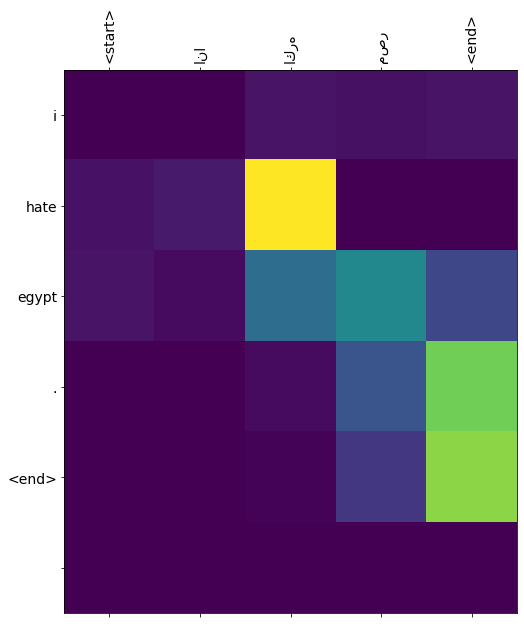

In [36]:
# and now let's see the translation
translate(u' انا اكره مصر ')